In [1]:
import os.path, sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
%pylab inline
import torch

from medicalCommon import SmallMedicalLoader

Populating the interactive namespace from numpy and matplotlib


In [3]:
dataset_path = '/pio/lscratch/1/i279076/Medical/small-medical-22.h5'
batch_size = 4096
num_workers = 8

In [4]:
loader = SmallMedicalLoader(dataset_path=dataset_path, batch_size=batch_size, num_workers=num_workers)

train_loader = loader.train_loader()
test_loader = loader.test_loader()

In [5]:
data = []
for i, (batch, _) in enumerate(train_loader, 1):
    if i > len(train_loader) * 0.4: break
    data.append(batch)
    
data = torch.cat(data, 0)
data.shape  

torch.Size([102400, 3, 22, 22])

In [6]:
def normalize(X):
    m, _ = X.min(0)
    M, _ = X.max(0)
    return (X - m) / (M - m)

In [7]:
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

In [8]:
X = data.reshape(-1, 3 * 22 * 22).t()
ZCA = torch.tensor(zca_whitening_matrix(X)).float()
ZCA.shape

torch.Size([1452, 1452])

In [9]:
data, _ = next(iter(test_loader))

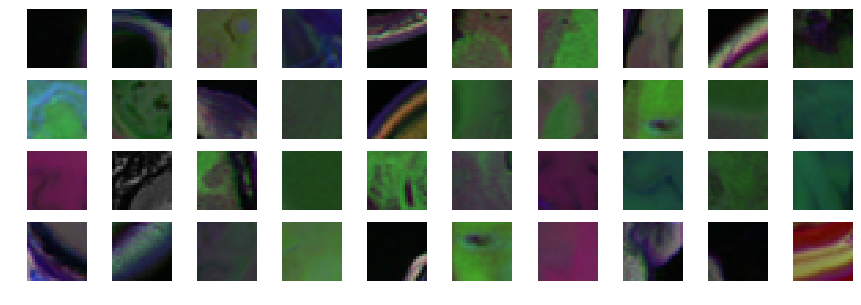

In [10]:
figsize(15, 5)
for i in range(40):
    subplot(4, 10, i + 1)
    axis('off')
    imshow(data[i].permute(1, 2, 0))
show()

In [11]:
whitened_data = (ZCA @ data.reshape(-1, 3 * 22 * 22).t()).t().reshape(*data.shape)

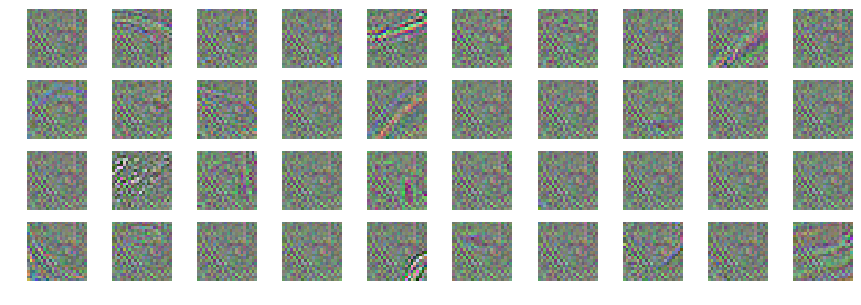

In [12]:
figsize(15, 5)
for i in range(40):
    subplot(4, 10, i + 1)
    axis('off')
    imshow(normalize(whitened_data)[i].permute(1, 2, 0))
show()

In [13]:
inversed_data = (ZCA.inverse() @ whitened_data.reshape(-1, 3 * 22 * 22).t()).t().reshape(*data.shape)

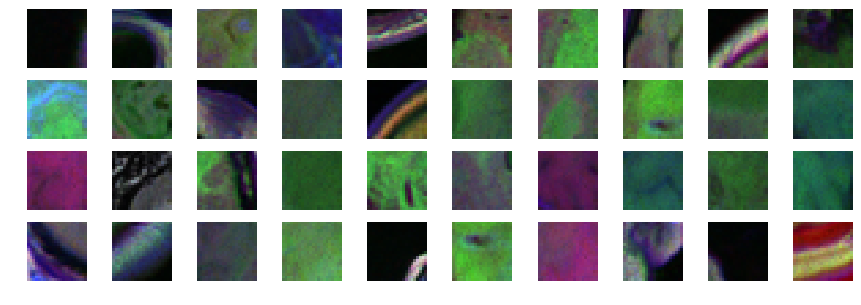

In [14]:
figsize(15, 5)
for i in range(40):
    subplot(4, 10, i + 1)
    axis('off')
    imshow(normalize(inversed_data)[i].permute(1, 2, 0))
show()

In [15]:
ZCA_inv = ZCA.inverse()

In [16]:
pos_mse, neg_mse = [], []

for data, labels in test_loader:
    recon_data = (ZCA_inv @ (ZCA @ data.reshape(-1, 3 * 22 * 22).t())).t().reshape(-1, 3, 22, 22)
    mse = ((recon_data - data)**2).reshape(-1, 3 * 22 * 22).sum(1)
    
    pos_mse.extend([v.item() for v in mse[(labels == 1).nonzero()].view(-1)])
    neg_mse.extend([v.item() for v in mse[(labels == 0).nonzero()].view(-1)])

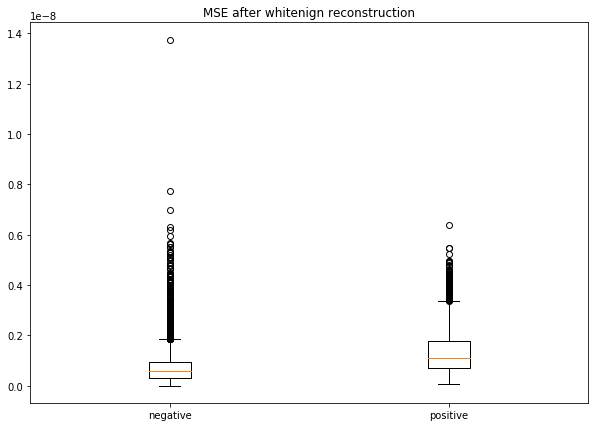

In [17]:
figsize(10, 7)
boxplot([neg_mse, pos_mse], labels=['negative', 'positive'])
title('MSE after whitenign reconstruction')
show()